In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.func import functional_call, grad
from torch.utils.data import TensorDataset, DataLoader

#Physics Informed Neural Networks (PINN)

### Solving Differential Equations with a neural network
To solve:   $\frac{df}{dt} = f(t)(1-f(t))$ \\
Solution:   $f(t) = \dfrac{1}{1+e^{-t}}$


Text(-4, 0.9, 'f(t)=1/(1+exp(-t))')

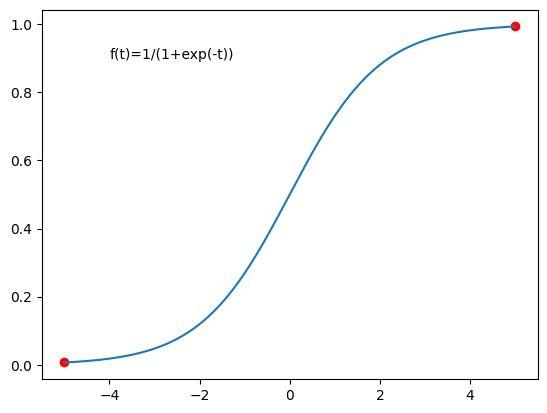

In [ ]:
f = lambda t: 1/(1+np.exp(-t))
t = np.linspace(-5,5,1000)

t_start_end = np.array([-5,5])
y_start_end = f(t_start_end)

plt.plot(t,f(t))
plt.scatter(t_start_end,y_start_end, c="r")
plt.text(-4,0.9,"f(t)=1/(1+exp(-t))")

### Design simple Neural Network

In [ ]:
class network(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.lin1 = torch.nn.Linear(1,8)
    self.lin2 = torch.nn.Linear(8,8)
    self.lin3 = torch.nn.Linear(8,8)
    self.lin4 = torch.nn.Linear(8,1)

  def forward(self, t):

    if type(t) != torch.Tensor:
      t=torch.tensor([t]).float()

    t = torch.nn.functional.tanh(self.lin1(t))
    t = torch.nn.functional.tanh(self.lin2(t))
    t = torch.nn.functional.tanh(self.lin3(t))
    return self.lin4(t)

## Build the loss function

compute loss on $M$ sample points in

$\text{physics_informed_loss} = ∑_{i=0}^M(\frac{dnet}{dt_i} - net(t_i)(1-net(t_i)))^2 + (net(0) - 0.5)^2$
\
\
$\text{data_loss} = \sum_{i=0}^N (net(p_i) - y_i)^2$
\
\
$\text{total_loss} = \text{physics_informed_loss + data_loss}$

In [ ]:
def pinn_loss(dnet, net, y):
  inner = (dnet[0] - y * (1 - y))**2
  boundary = (net(torch.tensor([0.0], requires_grad=True)) - 0.5)**2
  return inner + boundary

In [ ]:
X = torch.tensor(t.reshape(-1,1))
y = f(X)

batch_size = 64
n_epochs = 1000

train_data = TensorDataset(X,y)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

net = network()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 1, 0.001, total_iters=n_epochs)
data_Loss = torch.nn.MSELoss()

<ipython-input-134-6796f93b02b4>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(t.reshape(-1,1))


In [ ]:
for epoch in range(n_epochs):
  running_loss = 0

  for t, y in train_loader:

    t.requires_grad = True
    o = net(t.float().reshape(-1,1))

    dnet = torch.autograd.grad((oi for oi in o), t, retain_graph=True, create_graph=False)
    intermediate_loss = pinn_loss(dnet, net, o)
    loss_physics = torch.div(intermediate_loss, batch_size)

    o_data = net(torch.tensor(t_start_end.reshape(2,1)).float())
    loss_data = data_Loss(o_data.float().squeeze(), torch.tensor(y_start_end).float())


    loss = torch.mean(loss_data + loss_physics)
    running_loss += loss.item()

    loss.backward()
    optimizer.step()
    lr_scheduler.step()

    optimizer.zero_grad()


  if epoch%100==0:
    print(f"epoch: {epoch} \n\t loss: {running_loss/100}")

epoch: 0 
	 loss: 0.005006204849915573
epoch: 100 
	 loss: 6.050642684855604e-07
epoch: 200 
	 loss: 1.3774184573124369e-07
epoch: 300 
	 loss: 3.364329811479887e-08
epoch: 400 
	 loss: 1.7996605296911834e-08
epoch: 500 
	 loss: 1.3380040132301582e-08
epoch: 600 
	 loss: 1.1109141976984508e-08
epoch: 700 
	 loss: 9.754166462087026e-09
epoch: 800 
	 loss: 8.92450579308154e-09
epoch: 900 
	 loss: 8.463531014940301e-09


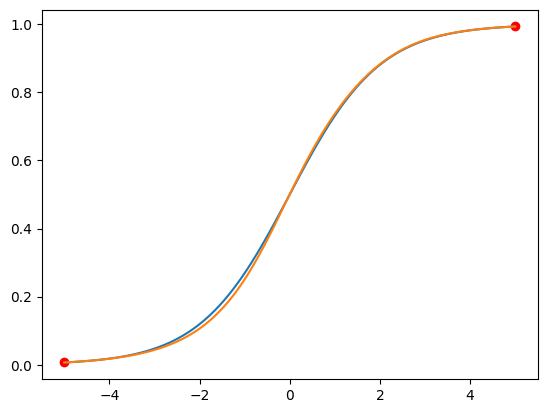

In [ ]:
domain = np.linspace(-5,5,100)
plt.plot(domain,f(domain))
plt.plot(domain,net(torch.tensor([domain]).float().reshape(100,1)).detach())
plt.scatter(t_start_end,y_start_end, c="r")

In [ ]:
!pip install pysr
import pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.3/76.3 kB 2.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/juliacall/__init__.py:60: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/pysr/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /usr/local/lib/python3.10/dist-packages/juliapkg/juliapkg.json
[juliapkg] Locating Julia ~1.6.7, ~1.7, ~1.8, ~1.9, =1.10.0, ^1.10.3
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.10.4 to /root/.julia/environments/pyjuliapkg/pyjuliapkg/install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to
[juliapkg]   have Julia installed in multiple locations. It is recommended to
[juliapkg]   install JuliaUp (https://github.com/JuliaLang/juliaup) or Julia
[juliapkg]   (https://julialang.org/downloads) yourself.
[juliapkg] Downloading Julia from https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.4-linux-x86_64.tar.gz
             download complete
[jul

In [ ]:
model = pysr.PySRRegressor(
    niterations=40,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "exp",
        "inv(x) = 1/x",
        "cos"
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)

In [ ]:
X = np.linspace(-5,5,500)
model.fit(X.reshape(500,1), net(torch.tensor(X.reshape(500,1)).float()).detach())

/usr/local/lib/python3.10/dist-packages/pysr/sr.py:1307: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 4.050e+04
Head worker occupation: 10.3%
Progress: 85 / 600 total iterations (14.167%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           1.492e-01  7.971e+00  y = cos(1.0486)
4           1.316e-01  6.287e-02  y = cos(cos(exp(x₀)))
5           8.243e-02  4.679e-01  y = cos(exp(x₀ * -0.19488))
6           3.633e-03  3.122e+00  y = exp(inv(-1.4606 * exp(x₀)))
7           6.754e-04  1.682e+00  y = inv(exp(inv(exp(x₀) + 0.28952)))
8           5.460e-04  2.126e-01  y = inv(exp(inv(inv(3.1059) + exp(x₀))))
9           4.238e-04  2.533e-01  y = inv(exp(inv(exp(0.17438 + x₀) + 0.2624)))
10          3.553e-04  1.763e-01  y = inv(exp(inv(exp(x₀) + 0.2624) * inv(1.1509)))
12          2.480e-04  1.798e-01  y = inv(exp(inv(exp((x₀ + exp(x₀ * 0.43222)) * 0.43222))))
14          2.018e-04  1.030e-01  y = inv(exp(inv((-0.36555 + cos(cos(cos(cos(inv(x₀))

PySRRegressor.equations_ = [
	    pick         score                                           equation  \
	0         0.000000e+00                                         -2.1353068   
	1         3.860558e+00                                     cos(1.0486151)   
	2         6.287356e-02                                  cos(cos(exp(x0)))   
	3         2.896598e+00                     0.49876526 + (0.13026361 * x0)   
	4         5.341030e+00                      inv(1.0006227 + inv(exp(x0)))   
	5         8.602679e-01             inv(exp(-0.97080785 * x0) + 1.0006227)   
	6         8.063553e-02  -0.0034542466 + inv(exp(-0.005564139) + exp(-0...   
	7         1.729765e-07  -0.0034542466 + inv(exp(-0.005564139) + exp(in...   
	8         7.567782e-06  (-0.0031307088 * 1.105742) + inv(exp(x0 * -0.9...   
	9         1.200535e-02  (exp(0.59612787) * -0.0021146452) + inv(exp((x...   
	10  >>>>  8.822233e-02  -0.0021146452 + inv(exp((-0.9573867 + ((-0.002...   
	11        3.495830e-02  -0.0021146452 + inv(exp((-0.9573867 + ((-0.002...   
	12        8.283699e-04  -0.0021146452 + inv(exp((-0.9573867 + ((-0.002...   
	
	        loss  complexity  
	0   7.087574           1  
	1   0.149238           2  
	2   0.131604           4  
	3   0.007266           5  
	4   0.000035           6  
	5   0.000015           7  
	6   0.000012          10  
	7   0.000012          12  
	8   0.000012          14  
	9   0.000011          15  
	10  0.000010          16  
	11  0.000010          18  
	12  0.000010          20  
]